# NHL MVP Analysis

In this project we try to use machine learning to predict winners of the Hart, Ted Lindsay, Norris, Vezina, and maybe Calder trophy. I expect Calder and Vezina are going to be very easy as there's typically only 2-3 people competing in any given year. Arguably the same can be said for the other trophies but there might be more variability. 

Hockey statistics will come from Evolving Hockey and Hockey-Reference. My general plan is to do some basic data analysis to pretend I'm doing data science, and then throw an ensemble from sklearn at it. 

In any given year, I'll take the top 10 players receiving votes, and we will try to predict their vote share in the final result. This is likely to be a very unbalanced distribution, so log normalization might work well. For example, below are shown the NHL voting data for the Hart trophy in the 17-18 season. Vote share approximately follows $e^{-x/\xi}$. By observation, in any given year there are usually two at most "serious contenders" for Hart, and often the winner has on the order of 50 to 100% more votes than second place.

In [1]:
import numpy as np
import pandas as pd
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

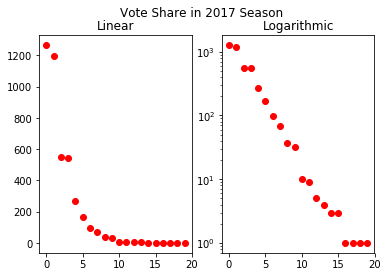

In [2]:
sample_vote = pd.read_csv("2017mvp.csv")
sample_vote.columns.values
vote_share = sample_vote["Votes"]

fig = plt.figure()

ax = plt.subplot(121)
ax.plot(vote_share,'ro')
ax.set_title("Linear")
plt.suptitle("Vote Share in 2017 Season")

ax=plt.subplot(122)
ax.semilogy(vote_share,'ro')
ax.set_title("Logarithmic")
plt.show()

In [3]:


# import full data
full_data= pd.read_csv("hockey-data-hart.csv")

stats_train, stats_test = train_test_split(full_data)

full_data

# full_data[pd.notna(full_data['first'])]
full_data[full_data['first'].notna()]

,Year,player,age,team_id,pos,votes,pct_of_vote,first,second,third,...,plus_minus,wins_goalie,losses_goalie,ties_goalie,goals_against_avg,save_pct,ops,dps,gps,ps
119,1947,Maurice Richard,25,Montreal Canadiens,RW,48.0,88.89,12.0,6.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.3,1.4,0.0,9.7
120,1947,Milt Schmidt,28,Boston Bruins,C,28.0,51.85,4.0,6.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5.6,1.1,0.0,6.6
121,1947,Max Bentley,26,Chicago Black Hawks,C,12.0,22.22,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.6,0.2,0.0,6.9
122,1947,Turk Broda,32,Toronto Maple Leafs,G,7.0,12.96,0.0,3.0,1.0,...,NaN,31.0,19.0,10.0,2.87,NaN,0.0,0.0,11.6,11.6
123,1947,Chuck Rayner,26,New York Rangers,G,7.0,12.96,0.0,1.0,5.0,...,NaN,22.0,30.0,6.0,3.05,NaN,0.0,0.0,10.2,10.2
124,1948,Buddy O'Connor,31,New York Rangers,C,36.0,80.00,10.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5.6,0.7,0.0,6.3
125,1948,Frank Brimsek,32,Boston Bruins,G,18.0,40.00,2.0,4.0,4.0,...,NaN,23.0,24.0,13.0,2.80,NaN,0.0,0.0,10.7,10.7
126,1948,Elmer Lach,30,Montreal Canadiens,C,13.0,28.89,1.0,5.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.5,1.0,0.0,7.5
127,1948,Max Bentley,27,TOT,C,10.0,22.22,2.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5.1,1.1,0.0,6.2
128,1949,Sid Abel,30,Detroit Red Wings,C,43.0,39.81,11.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.2,1.0,0.0,7.3


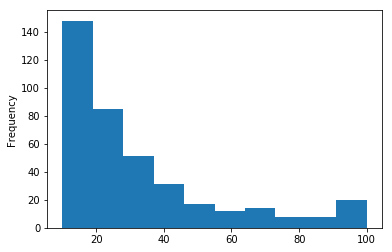

In [4]:
# (full_data['pos'].value_counts()/len(full_data)).plot.bar()

full_data[full_data['pct_of_vote']>10]['pct_of_vote'].plot.hist()

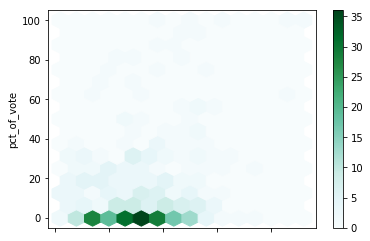

In [5]:
fd=full_data.drop(['first','second','third','fourth','fifth'],axis=1)
fd=fd.dropna(axis=0,subset=['pct_of_vote'])
fd[fd['goals']>0].sample(400).plot.hexbin(x='goals',y='pct_of_vote',gridsize=15)

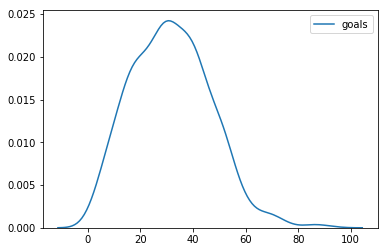

In [14]:
sns.kdeplot(fd[fd['goals']>0]['goals'])

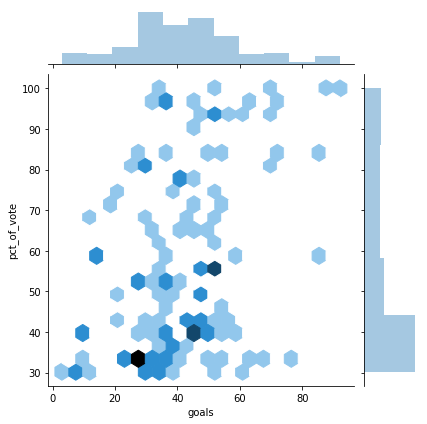

In [38]:
sns.jointplot(x='goals',y='pct_of_vote',data = fd[(fd['goals']>0) & (fd['pct_of_vote']>30)], kind='hex', gridsize=20)

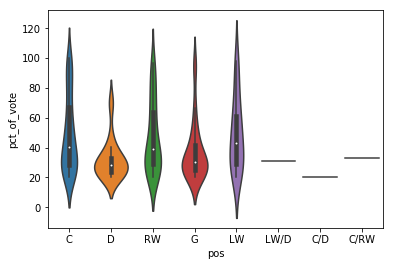

In [41]:
sns.violinplot(x='pos',y='pct_of_vote',data=fd[fd['pct_of_vote']>20])